<a href="https://colab.research.google.com/github/Tikare234/praveen/blob/master/Plant_Seedling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout
plt.rcParams['font.size']=14
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
import os

# Set the environment variable with the correct path to the uploaded JSON file.
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
!kaggle competitions download -c plant-seedlings-classification

 99% 1.67G/1.69G [00:17<00:00, 145MB/s]
100% 1.69G/1.69G [00:17<00:00, 105MB/s]


In [4]:
import zipfile

# Define the path to the ZIP file and the target directory for extraction
zip_file_path = "/content/plant-seedlings-classification.zip"  # Replace with the actual path
extract_dir = "/content"  # Replace with the desired extraction path

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['.config', 'test', 'train', 'kaggle.json', 'sample_submission.csv', 'plant-seedlings-classification.zip', 'sample_data']


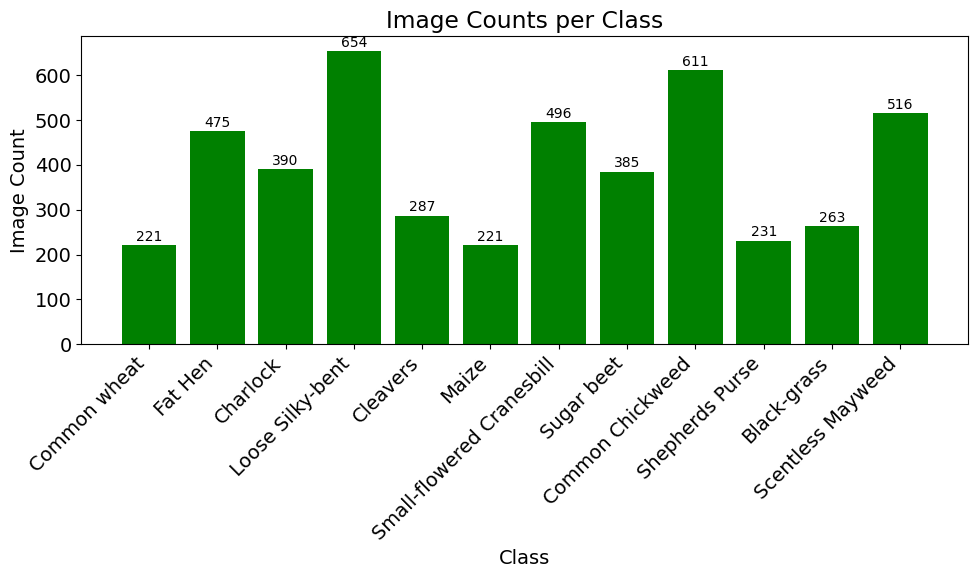

In [5]:
import os
import matplotlib.pyplot as plt

# Directory containing subdirectories for each class
root_dir = "/content/train/"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Create a dictionary to store the count of images for each class
class_counts = {}

# Loop through each class directory and count the images
for class_dir in class_dirs:
    class_path = os.path.join(root_dir, class_dir)
    # Get the list of files (images) in the class directory
    class_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    # Store the count in the dictionary
    class_counts[class_dir] = len(class_files)

# Extract class names and counts for plotting
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, image_counts, color='green')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Image Counts per Class')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Annotate the counts on top of each bar
for bar, count in zip(bars, image_counts):
    plt.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()

# Show the plot
plt.show()


In [7]:
import os
import shutil
import random
from PIL import Image
from tqdm import tqdm  # For the progress bar
from PIL import ImageEnhance

# Define the desired number of images per class for oversampling
desired_images_per_class = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_per_class - subdirectory_count

    if num_images_needed > 0:
        # Create a subdirectory in the oversampled directory for the subdirectory
        oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
        os.makedirs(oversampled_subdirectory_path, exist_ok=True)

        # Copy existing images to the oversampled directory
        for image_name in subdirectory_images:
            source_path = os.path.join(subdirectory_path, image_name)
            dest_path = os.path.join(oversampled_subdirectory_path, image_name)
            shutil.copy(source_path, dest_path)

        # Generate additional images for the subdirectory until the desired count is reached
        while num_images_needed > 0:
            # Randomly select an existing image to augment
            existing_image_name = random.choice(subdirectory_images)
            existing_image_path = os.path.join(subdirectory_path, existing_image_name)

            # Load the image using PIL
            image = Image.open(existing_image_path)

            # Apply data augmentation techniques
            augmented_image = apply_data_augmentation(image)

            # Save the augmented image
            new_image_name = f'aug_{existing_image_name}'
            new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
            augmented_image.save(new_image_path)

            # Update the count
            num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Maize'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")






<ipython-input-7-8c34c59c4b4d>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Maize':
Subdirectory 'Maize': 417 images


In [14]:
import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance  # Import ImageEnhance
from tqdm import tqdm  # For the progress bar

# Define the desired number of images for the specific subdirectory
desired_images_for_subdirectory = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    # Make sure we don't exceed the desired count
    num_images_needed = min(num_images_needed, desired_images_for_subdirectory)

    # Create a subdirectory in the oversampled directory for the subdirectory
    oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
    os.makedirs(oversampled_subdirectory_path, exist_ok=True)

    # Copy existing images to the oversampled directory
    for image_name in subdirectory_images:
        source_path = os.path.join(subdirectory_path, image_name)
        dest_path = os.path.join(oversampled_subdirectory_path, image_name)
        shutil.copy(source_path, dest_path)

    # Generate additional images for the subdirectory until the desired count is reached
    while num_images_needed > 0:
        # Randomly select an existing image to augment
        existing_image_name = random.choice(subdirectory_images)
        existing_image_path = os.path.join(subdirectory_path, existing_image_name)

        # Load the image using PIL
        image = Image.open(existing_image_path)

        # Apply data augmentation techniques
        augmented_image = apply_data_augmentation(image)

        # Save the augmented image
        new_image_name = f'aug_{existing_image_name}'
        new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
        augmented_image.save(new_image_path)

        # Update the count
        num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Black-grass'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")



<ipython-input-14-c07a2805ab9b>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Black-grass':
Subdirectory 'Black-grass': 464 images


In [16]:
import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance  # Import ImageEnhance
from tqdm import tqdm  # For the progress bar

# Define the desired number of images for the specific subdirectory
desired_images_for_subdirectory = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    # Make sure we don't exceed the desired count
    num_images_needed = min(num_images_needed, desired_images_for_subdirectory)

    # Create a subdirectory in the oversampled directory for the subdirectory
    oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
    os.makedirs(oversampled_subdirectory_path, exist_ok=True)

    # Copy existing images to the oversampled directory
    for image_name in subdirectory_images:
        source_path = os.path.join(subdirectory_path, image_name)
        dest_path = os.path.join(oversampled_subdirectory_path, image_name)
        shutil.copy(source_path, dest_path)

    # Generate additional images for the subdirectory until the desired count is reached
    while num_images_needed > 0:
        # Randomly select an existing image to augment
        existing_image_name = random.choice(subdirectory_images)
        existing_image_path = os.path.join(subdirectory_path, existing_image_name)

        # Load the image using PIL
        image = Image.open(existing_image_path)

        # Apply data augmentation techniques
        augmented_image = apply_data_augmentation(image)

        # Save the augmented image
        new_image_name = f'aug_{existing_image_name}'
        new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
        augmented_image.save(new_image_path)

        # Update the count
        num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Shepherds Purse'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")


<ipython-input-16-991b56d7ac7b>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Shepherds Purse':
Subdirectory 'Shepherds Purse': 423 images


In [19]:
import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance  # Import ImageEnhance
from tqdm import tqdm  # For the progress bar

# Define the desired number of images for the specific subdirectory
desired_images_for_subdirectory = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    # Make sure we don't exceed the desired count
    num_images_needed = min(num_images_needed, desired_images_for_subdirectory)

    # Create a subdirectory in the oversampled directory for the subdirectory
    oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
    os.makedirs(oversampled_subdirectory_path, exist_ok=True)

    # Copy existing images to the oversampled directory
    for image_name in subdirectory_images:
        source_path = os.path.join(subdirectory_path, image_name)
        dest_path = os.path.join(oversampled_subdirectory_path, image_name)
        shutil.copy(source_path, dest_path)

    # Generate additional images for the subdirectory until the desired count is reached
    while num_images_needed > 0:
        # Randomly select an existing image to augment
        existing_image_name = random.choice(subdirectory_images)
        existing_image_path = os.path.join(subdirectory_path, existing_image_name)

        # Load the image using PIL
        image = Image.open(existing_image_path)

        # Apply data augmentation techniques
        augmented_image = apply_data_augmentation(image)

        # Save the augmented image
        new_image_name = f'aug_{existing_image_name}'
        new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
        augmented_image.save(new_image_path)

        # Update the count
        num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Charlock'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")


<ipython-input-19-ec95aa201403>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Charlock':
Subdirectory 'Charlock': 589 images


In [18]:
import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance  # Import ImageEnhance
from tqdm import tqdm  # For the progress bar

# Define the desired number of images for the specific subdirectory
desired_images_for_subdirectory = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    # Make sure we don't exceed the desired count
    num_images_needed = min(num_images_needed, desired_images_for_subdirectory)

    # Create a subdirectory in the oversampled directory for the subdirectory
    oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
    os.makedirs(oversampled_subdirectory_path, exist_ok=True)

    # Copy existing images to the oversampled directory
    for image_name in subdirectory_images:
        source_path = os.path.join(subdirectory_path, image_name)
        dest_path = os.path.join(oversampled_subdirectory_path, image_name)
        shutil.copy(source_path, dest_path)

    # Generate additional images for the subdirectory until the desired count is reached
    while num_images_needed > 0:
        # Randomly select an existing image to augment
        existing_image_name = random.choice(subdirectory_images)
        existing_image_path = os.path.join(subdirectory_path, existing_image_name)

        # Load the image using PIL
        image = Image.open(existing_image_path)

        # Apply data augmentation techniques
        augmented_image = apply_data_augmentation(image)

        # Save the augmented image
        new_image_name = f'aug_{existing_image_name}'
        new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
        augmented_image.save(new_image_path)

        # Update the count
        num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Sugar beet'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")


<ipython-input-18-6f61a4b7744f>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Sugar beet':
Subdirectory 'Sugar beet': 583 images


In [25]:
import os
import shutil

# Source directory (contains the classes you want to copy)
source_directory = '/content/train'

# Destination directory (where you want to paste the selected classes)
destination_directory = '/content/oversampled_train'

# List of classes you want to copy
classes_to_copy = [
    'Fat Hen',
    'Loose Silky-bent',
    'Small-flowered Cranesbill',
    'Common Chickweed',
    'Scentless Mayweed'
]

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Loop through the classes and copy them to the destination
for class_name in classes_to_copy:
    source_class_dir = os.path.join(source_directory, class_name)
    destination_class_dir = os.path.join(destination_directory, class_name)

    # Use shutil.copytree to copy the entire class directory and its contents
    shutil.copytree(source_class_dir, destination_class_dir)

print("Selected classes copied to the destination directory.")



Selected classes copied to the destination directory.


In [26]:
import os

# Directory containing subdirectories for each class
root_dir = "/content/oversampled_train"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Create a dictionary to store the count of images for each class
class_counts = {}

# Loop through each class directory and count the images
for class_dir in class_dirs:
    class_path = os.path.join(root_dir, class_dir)
    # Get the list of files (images) in the class directory
    class_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    # Store the count in the dictionary
    class_counts[class_dir] = len(class_files)

# Print the count of images for each class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")


Class 'Common wheat': 409 images
Class 'Fat Hen': 475 images
Class 'Charlock': 589 images
Class 'Loose Silky-bent': 654 images
Class 'Cleavers': 491 images
Class 'Maize': 417 images
Class 'Small-flowered Cranesbill': 496 images
Class 'Sugar beet': 583 images
Class 'Common Chickweed': 611 images
Class 'Shepherds Purse': 423 images
Class 'Black-grass': 464 images
Class 'Scentless Mayweed': 516 images


In [9]:
import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance  # Import ImageEnhance
from tqdm import tqdm  # For the progress bar

# Define the desired number of images for the specific subdirectory
desired_images_for_subdirectory = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    if num_images_needed > 0:
        # Create a subdirectory in the oversampled directory for the subdirectory
        oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
        os.makedirs(oversampled_subdirectory_path, exist_ok=True)

        # Generate additional images for the subdirectory until the desired count is reached
        while num_images_needed > 0:
            # Randomly select an existing image to augment
            existing_image_name = random.choice(subdirectory_images)
            existing_image_path = os.path.join(subdirectory_path, existing_image_name)

            # Load the image using PIL
            image = Image.open(existing_image_path)

            # Apply data augmentation techniques
            augmented_image = apply_data_augmentation(image)

            # Save the augmented image
            new_image_name = f'aug_{existing_image_name}'
            new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
            augmented_image.save(new_image_path)

            # Update the count
            num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Common wheat'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")


<ipython-input-9-f4b95dee3578>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Common wheat':
Subdirectory 'Common wheat': 180 images


In [12]:

import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance  # Import ImageEnhance
from tqdm import tqdm  # For the progress bar

# Define the desired number of images for the specific subdirectory
desired_images_for_subdirectory = 654

# Directory paths
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)

    # Add Gaussian noise
    mean = 0
    stddev = random.uniform(0, 20)
    image_array = np.array(augmented_image)
    noise = np.random.normal(mean, stddev, image_array.shape).astype('uint8')
    augmented_image_with_noise = np.clip(image_array + noise, 0, 255).astype('uint8')
    augmented_image = Image.fromarray(augmented_image_with_noise)

    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(subdirectory_name):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    # Make sure we don't exceed the desired count
    num_images_needed = min(num_images_needed, desired_images_for_subdirectory)

    # Create a subdirectory in the oversampled directory for the subdirectory
    oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
    os.makedirs(oversampled_subdirectory_path, exist_ok=True)

    # Copy existing images to the oversampled directory
    for image_name in subdirectory_images:
        source_path = os.path.join(subdirectory_path, image_name)
        dest_path = os.path.join(oversampled_subdirectory_path, image_name)
        shutil.copy(source_path, dest_path)

    # Generate additional images for the subdirectory until the desired count is reached
    while num_images_needed > 0:
        # Randomly select an existing image to augment
        existing_image_name = random.choice(subdirectory_images)
        existing_image_path = os.path.join(subdirectory_path, existing_image_name)

        # Load the image using PIL
        image = Image.open(existing_image_path)

        # Apply data augmentation techniques
        augmented_image = apply_data_augmentation(image)

        # Save the augmented image
        new_image_name = f'aug_{existing_image_name}'
        new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
        augmented_image.save(new_image_path)

        # Update the count
        num_images_needed -= 1

# Create the oversampled directory if it doesn't exist
if not os.path.exists(oversampled_dir):
    os.makedirs(oversampled_dir)

# Specify the subdirectory you want to augment
subdirectory_to_augment = 'Cleavers'

# Call the oversample_subdirectory function for the specified subdirectory
oversample_subdirectory(subdirectory_to_augment)

# Display the updated class counts for the specified subdirectory
print(f"Updated Class Counts for '{subdirectory_to_augment}':")
subdirectory_images = [f for f in os.listdir(os.path.join(oversampled_dir, subdirectory_to_augment)) if f.lower().endswith('.png')]
subdirectory_count = len(subdirectory_images)
print(f"Subdirectory '{subdirectory_to_augment}': {subdirectory_count} images")



<ipython-input-12-3ac2f2959a35>:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


Updated Class Counts for 'Cleavers':
Subdirectory 'Cleavers': 491 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size
batch_size = 32
img_size=224
# Directory path for oversampled data
oversampled_train_dir = '/content/oversampled_train'

# Create the data generator with rescaling
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.15)

# Create the train generator with a portion of the data for validation
train_generator = datagen.flow_from_directory(
    oversampled_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,  # You can shuffle the data for training
    subset='training'  # Specify 'training' subset for the train generator
)

# Create the validation generator with a portion of the data
val_generator = datagen.flow_from_directory(
    oversampled_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Do not shuffle the data for validation
    subset='validation'  # Specify 'validation' subset for the validation generator
)


Found 5611 images belonging to 12 classes.
Found 984 images belonging to 12 classes.


In [ ]:
#preprocessing test images
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              data_format='channels_last')  # Specify 'channels_last' for PNG images
test_generator = test_datagen.flow_from_directory(
    directory='/content',
    classes=['test'],
    target_size=(img_size, img_size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Found 794 images belonging to 1 classes.


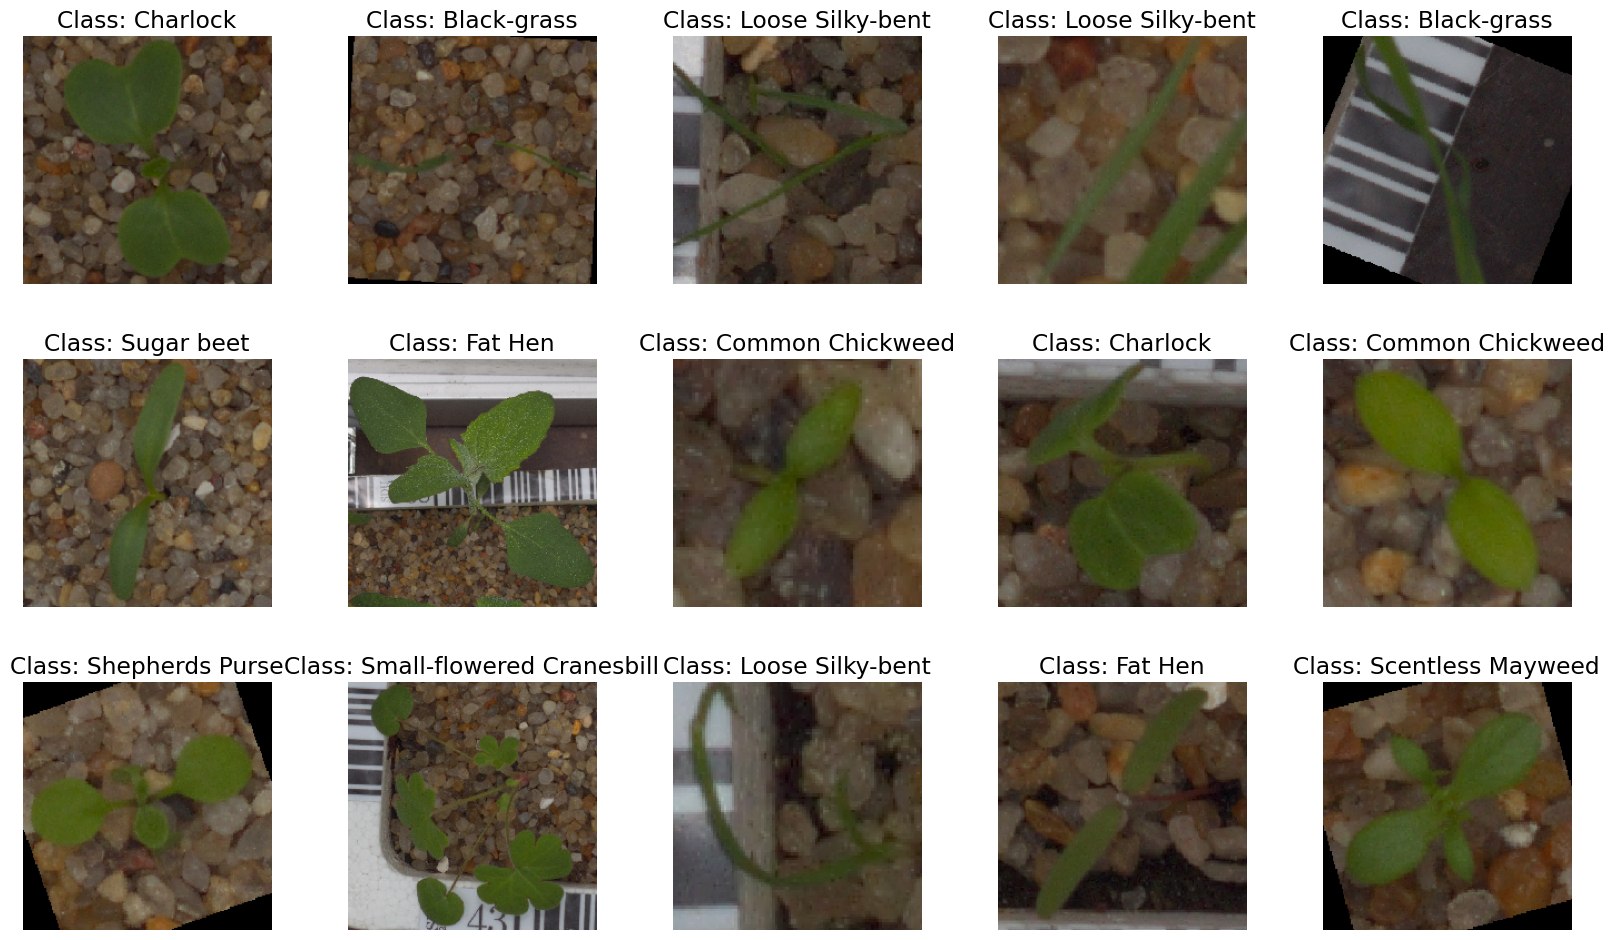

In [ ]:
#Plotting training images
label = [k for k in train_generator.class_indices]
samples = train_generator.__next__()
images = samples[0]
titles = samples[1]
plt.figure(figsize=(20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {label[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


Creating VGG16 Model

In [ ]:
#create the mdel
base_model_1=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
#Frezzing some layers
for layer in base_model_1.layers[:3]:
    layer.trainable = False

In [ ]:
#Compile the model
last_output = base_model_1.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)
model_1 = Model(inputs=base_model_1.inputs,outputs=outputs)
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Save the modeland add callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_name = "model_vgg.h5"
Checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
#Fit the model
history = model_1.fit(train_generator,epochs=50,validation_data=val_generator,callbacks=[Checkpoint,es,lrr])

Epoch 1/50
176/176 [==============================] - ETA: 0s - loss: 2.4792 - accuracy: 0.1016
Epoch 1: val_loss improved from inf to 2.43712, saving model to model_vgg.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 [==============================] - 125s 579ms/step - loss: 2.4792 - accuracy: 0.1016 - val_loss: 2.4371 - val_accuracy: 0.1280 - lr: 1.0000e-04
Epoch 2/50
176/176 [==============================] - ETA: 0s - loss: 2.3449 - accuracy: 0.1577
Epoch 2: val_loss improved from 2.43712 to 1.98673, saving model to model_vgg.h5
176/176 [==============================] - 94s 533ms/step - loss: 2.3449 - accuracy: 0.1577 - val_loss: 1.9867 - val_accuracy: 0.3049 - lr: 1.0000e-04
Epoch 3/50
176/176 [==============================] - ETA: 0s - loss: 1.7329 - accuracy: 0.3634
Epoch 3: val_loss improved from 1.98673 to 1.40091, saving model to model_vgg.h5
176/176 [==============================] - 102s 578ms/step - loss: 1.7329 - accuracy: 0.3634 - val_loss: 1.4009 - val_accuracy: 0.5325 - lr: 1.0000e-04
Epoch 4/50
176/176 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.5867
Epoch 4: val_loss improved from 1.40091 to 0.78347, saving model to model_vgg.h5
176/176 [=====

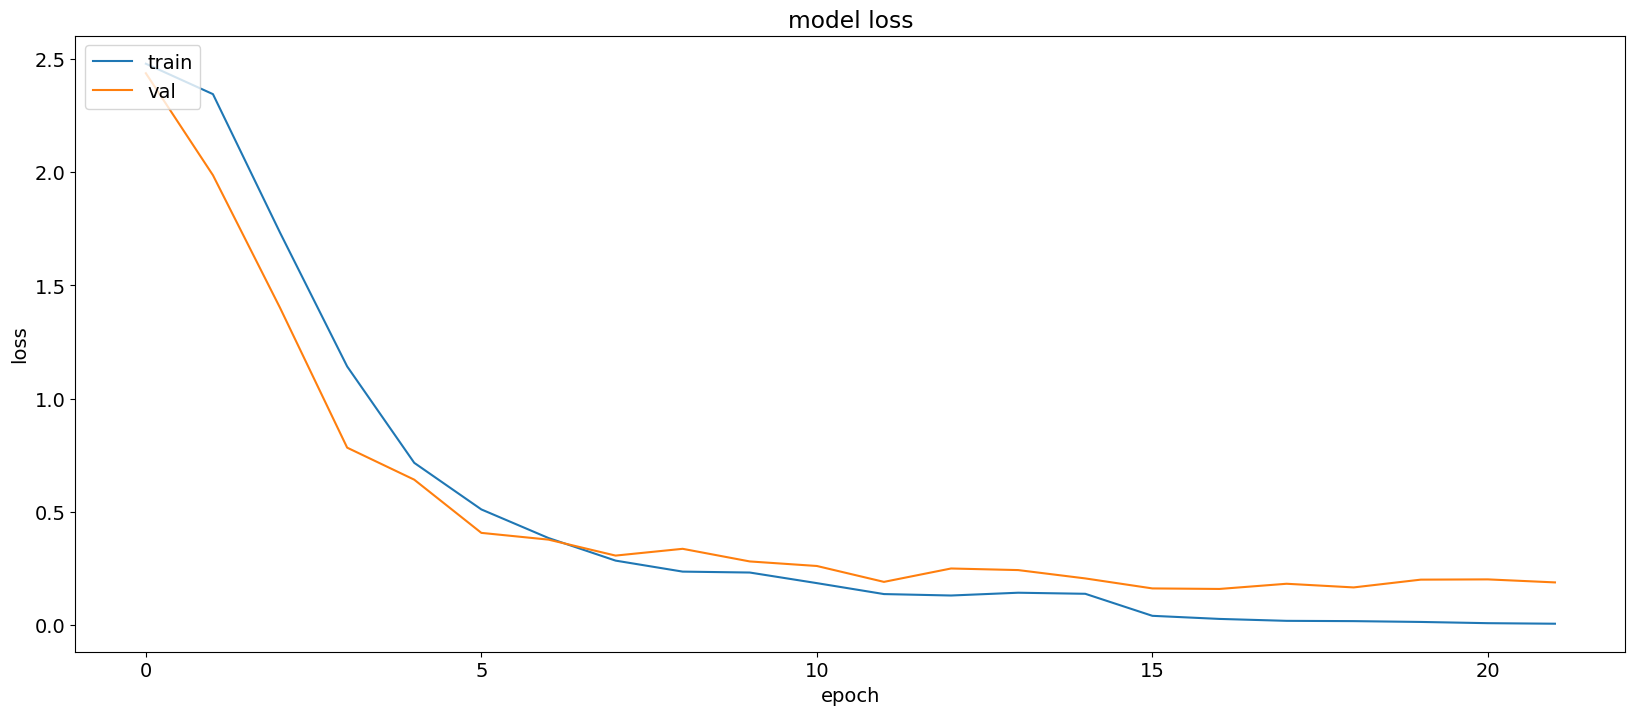

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_vgg.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

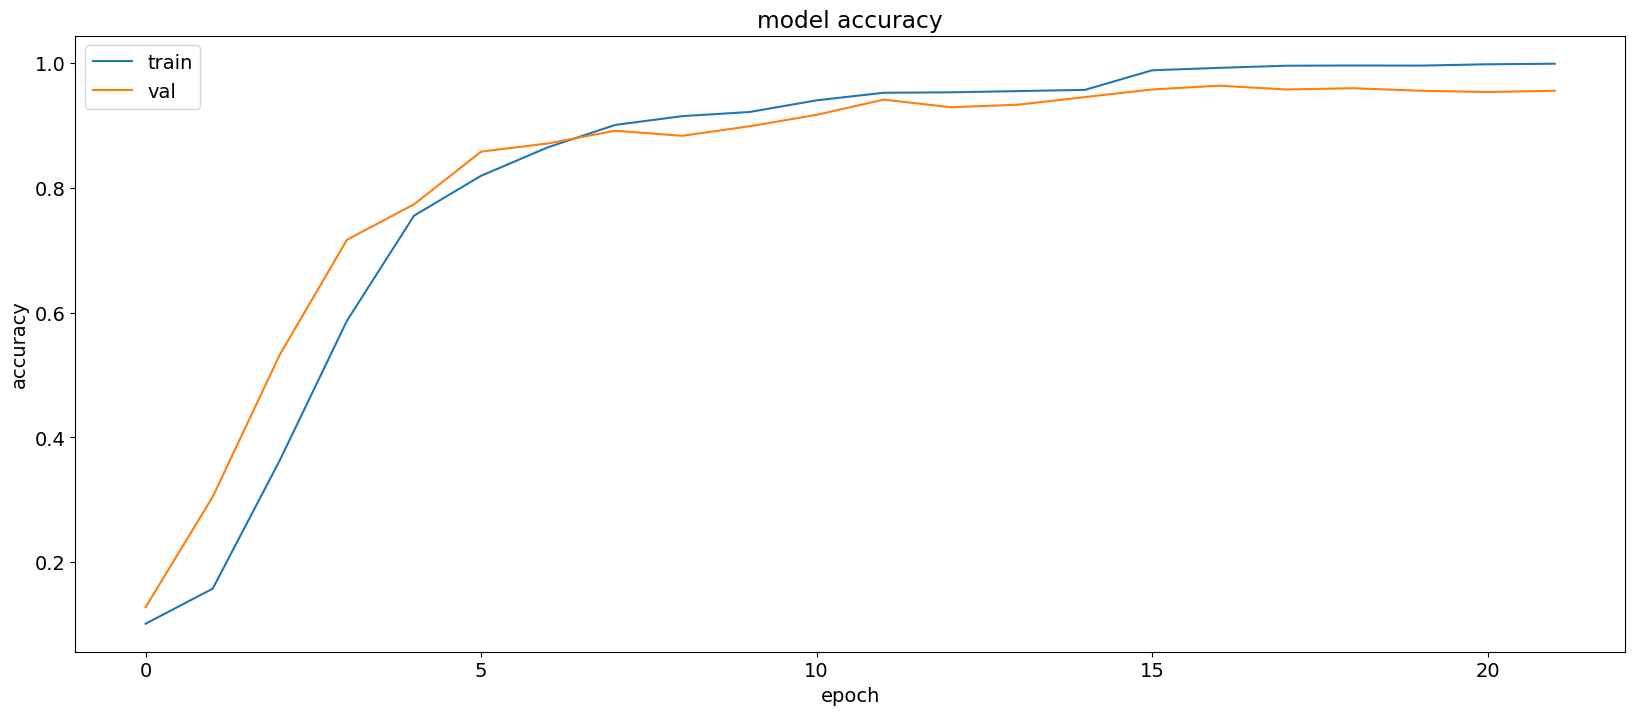

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

31/31 [==============================] - 12s 358ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.89      0.93      0.91        69
                 Charlock       0.98      1.00      0.99        88
                 Cleavers       0.97      0.96      0.97        72
         Common Chickweed       0.98      0.96      0.97        98
             Common wheat       0.98      0.95      0.97        61
                  Fat Hen       0.97      0.97      0.97        94
         Loose Silky-bent       0.94      0.94      0.94        99
                    Maize       0.98      0.97      0.98        61
        Scentless Mayweed       0.93      1.00      0.96        95
          Shepherds Purse       0.98      0.94      0.96        64
Small-flowered Cranesbill       0.99      0.97      0.98        96
               Sugar beet       0.98      0.97      0.97        87

                 accuracy                           0.96       984
                macro avg       0.96      0.96      0.96    

Confusion Matrix:
[[64  0  0  0  0  0  4  0  0  0  0  1]
 [ 0 88  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 69  1  0  0  0  0  1  0  0  1]
 [ 0  0  0 94  0  0  1  0  2  1  0  0]
 [ 1  0  0  0 58  2  0  0  0  0  0  0]
 [ 0  1  1  1  0 91  0  0  0  0  0  0]
 [ 6  0  0  0  0  0 93  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 59  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 95  0  0  0]
 [ 0  0  0  0  0  0  0  0  3 60  1  0]
 [ 0  0  1  0  1  1  0  0  0  0 93  0]
 [ 1  1  0  0  0  0  0  1  0  0  0 84]]


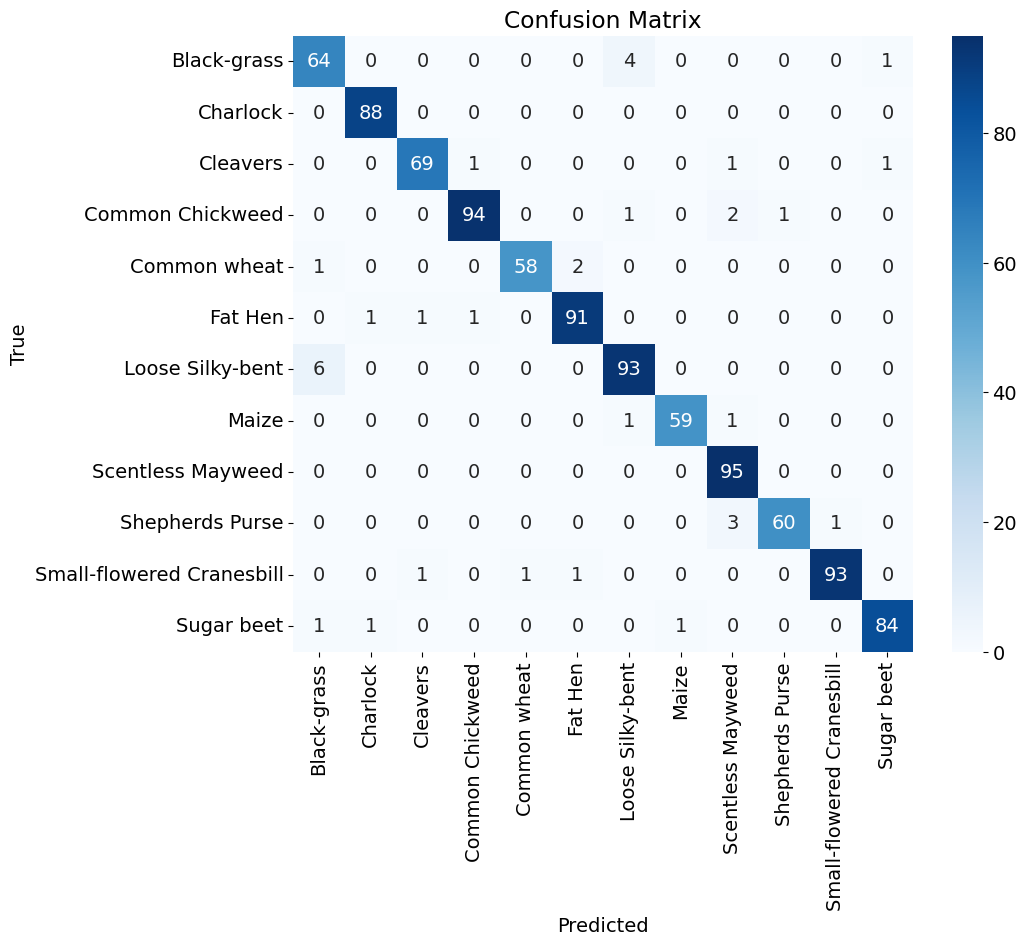

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model weights to a file
model.save_weights('model_vgg_weights.h5')

Create ResNet50 Model

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:


# Freeze some initial layers if needed
for layer in base_model.layers[:50]:
    layer.trainable = False
base_model.summary()



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Create the custom top layers for your new model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(12, activation='softmax')(x)

# Create the new model by specifying input and output layers
model = Model(inputs=base_model.inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
#Save the modeland add callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_name = "modelds.h5"
Checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
#fit the model
history = model.fit(train_generator,epochs=50,validation_data=val_generator,
                    callbacks=[Checkpoint,es,lrr])

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 2.0520 - accuracy: 0.3103
Epoch 1: val_loss improved from inf to 2.64501, saving model to modelds.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 164s 1s/step - loss: 2.0520 - accuracy: 0.3103 - val_loss: 2.6450 - val_accuracy: 0.0525 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 1.2094 - accuracy: 0.6003
Epoch 2: val_loss did not improve from 2.64501
112/112 [==============================] - 114s 1s/step - loss: 1.2094 - accuracy: 0.6003 - val_loss: 5.1348 - val_accuracy: 0.1379 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.7119
Epoch 3: val_loss did not improve from 2.64501
112/112 [==============================] - 118s 1s/step - loss: 0.8505 - accuracy: 0.7119 - val_loss: 3.3320 - val_accuracy: 0.1345 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.7522
Epoch 4: val_loss did not improve from 2.64501

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
112/112 [==============================] - 114

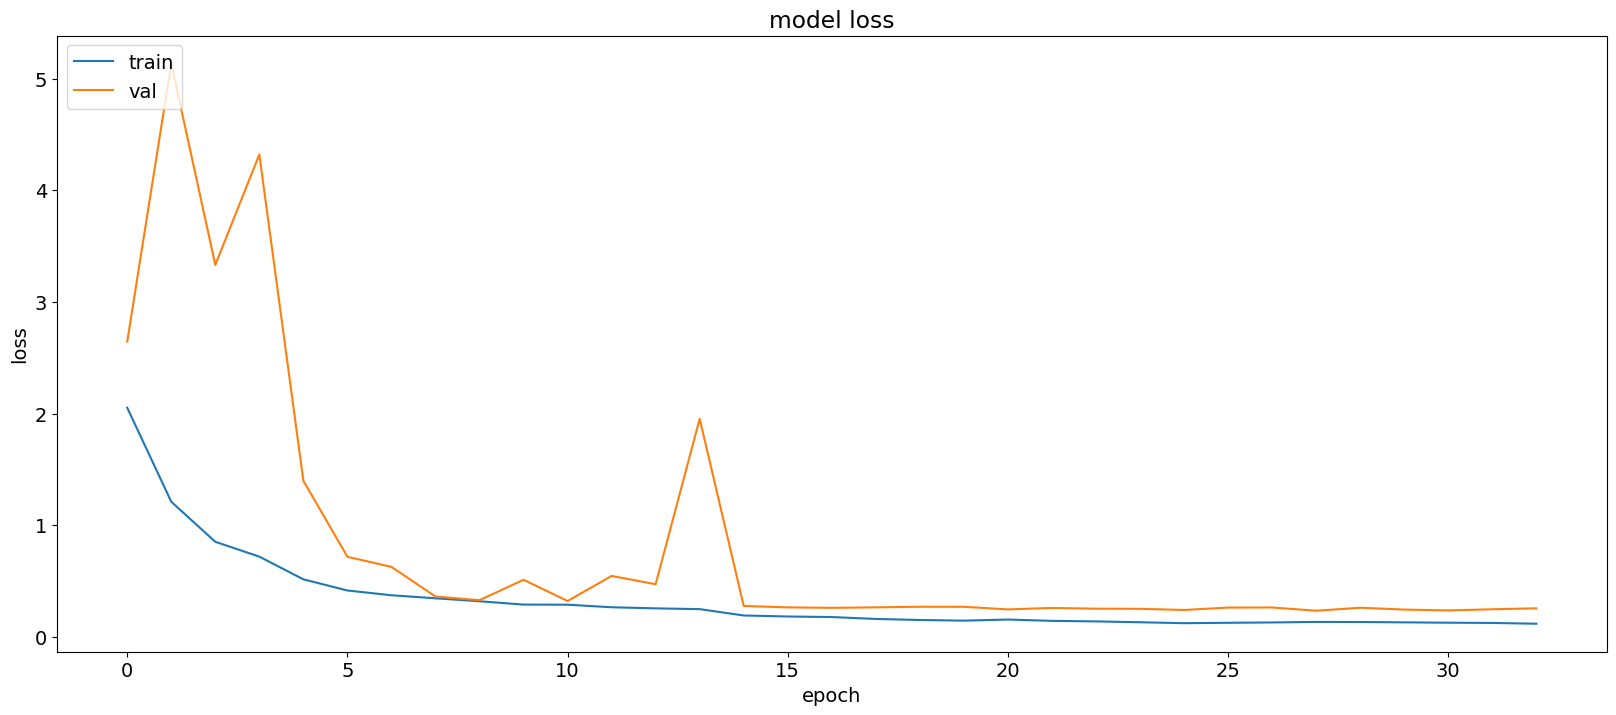

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/modelds.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

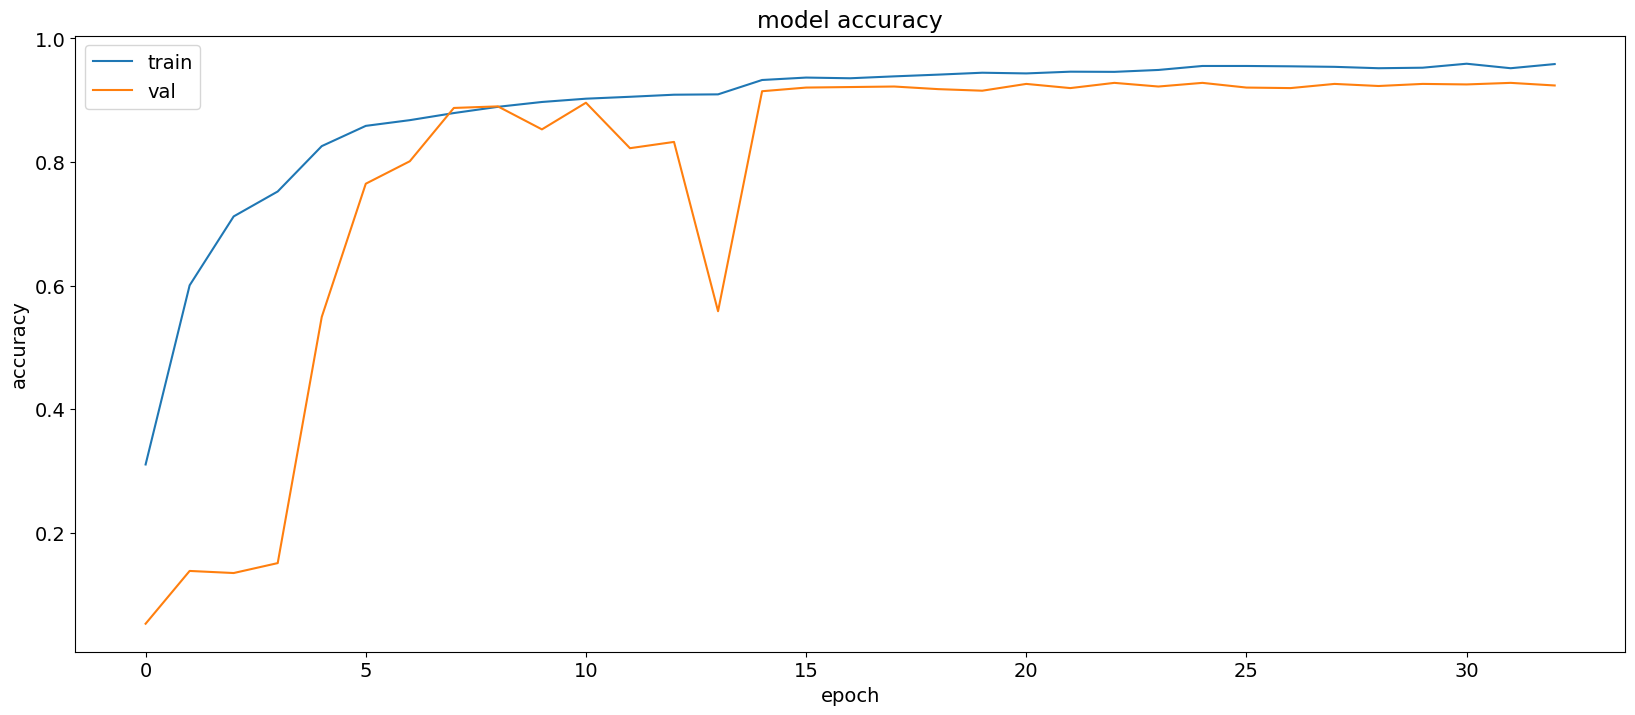

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

37/37 [==============================] - 30s 766ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.64      0.57      0.60        65
                 Charlock       0.98      0.98      0.98        97
                 Cleavers       0.92      0.93      0.92        71
         Common Chickweed       0.96      0.98      0.97       152
             Common wheat       0.95      0.98      0.96        55
                  Fat Hen       0.97      0.97      0.97       118
         Loose Silky-bent       0.83      0.88      0.86       163
                    Maize       0.91      0.96      0.94        55
        Scentless Mayweed       0.95      0.97      0.96       129
          Shepherds Purse       1.00      0.93      0.96        57
Small-flowered Cranesbill       1.00      0.98      0.99       124
               Sugar beet       1.00      0.93      0.96        96

                 accuracy                           0.93      1182
                macro avg       0.93      0.92      0.92    

Confusion Matrix:
[[ 37   0   0   0   2   0  26   0   0   0   0   0]
 [  0  95   2   0   0   0   0   0   0   0   0   0]
 [  0   1  66   1   0   1   0   1   1   0   0   0]
 [  0   0   1 149   0   0   1   0   1   0   0   0]
 [  1   0   0   0  54   0   0   0   0   0   0   0]
 [  1   1   1   0   0 115   0   0   0   0   0   0]
 [ 18   0   0   0   1   0 144   0   0   0   0   0]
 [  0   0   0   0   0   0   1  53   1   0   0   0]
 [  1   0   1   2   0   0   0   0 125   0   0   0]
 [  0   0   0   2   0   0   0   0   2  53   0   0]
 [  0   0   1   0   0   0   0   1   1   0 121   0]
 [  0   0   0   1   0   2   1   3   0   0   0  89]]


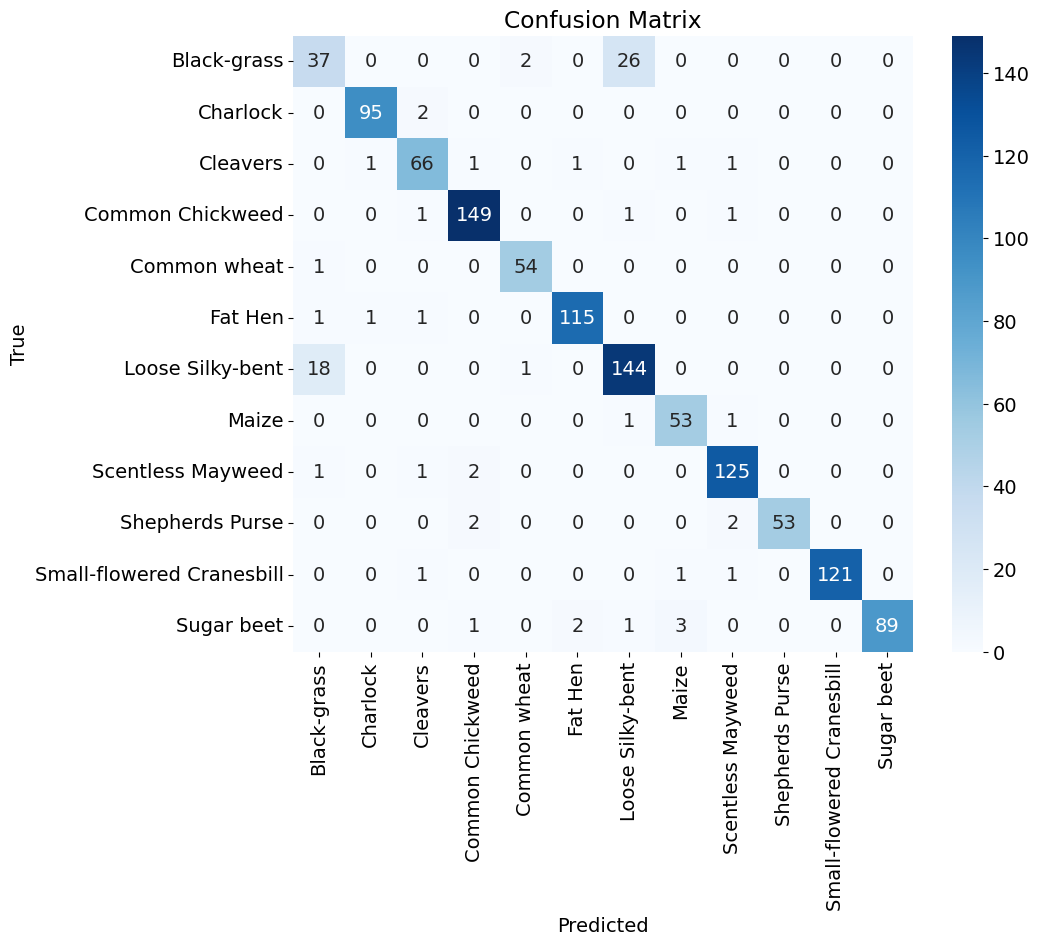

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the model weights to a file
model.save_weights('model_weights.h5')


Creating Inception_V3 model

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3


In [ ]:
base_model_2 = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze the first few layers
for layer in base_model_2.layers[:3]:
    layer.trainable = False

In [ ]:
# Add your custom output layers
last_output = base_model_2.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)

In [ ]:
# Create the InceptionV2-based model
model_2 = Model(inputs=base_model_2.inputs, outputs=outputs)

In [ ]:
# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Save the model and add callbacks
model_name = "model_inceptionv2.h5"
Checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
# Train the model
history = model_2.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[Checkpoint, es, lrr])

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.5807
Epoch 1: val_loss improved from inf to 0.65356, saving model to model_inceptionv2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 192s 1s/step - loss: 1.2824 - accuracy: 0.5807 - val_loss: 0.6536 - val_accuracy: 0.7657 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8649
Epoch 2: val_loss improved from 0.65356 to 0.41463, saving model to model_inceptionv2.h5
112/112 [==============================] - 133s 1s/step - loss: 0.4064 - accuracy: 0.8649 - val_loss: 0.4146 - val_accuracy: 0.8629 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9036
Epoch 3: val_loss improved from 0.41463 to 0.35819, saving model to model_inceptionv2.h5
112/112 [==============================] - 121s 1s/step - loss: 0.2754 - accuracy: 0.9036 - val_loss: 0.3582 - val_accuracy: 0.8824 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9297
Epoch 4: val_loss improved from 0.35819 to 0.24236, saving model to model_inceptionv2.h

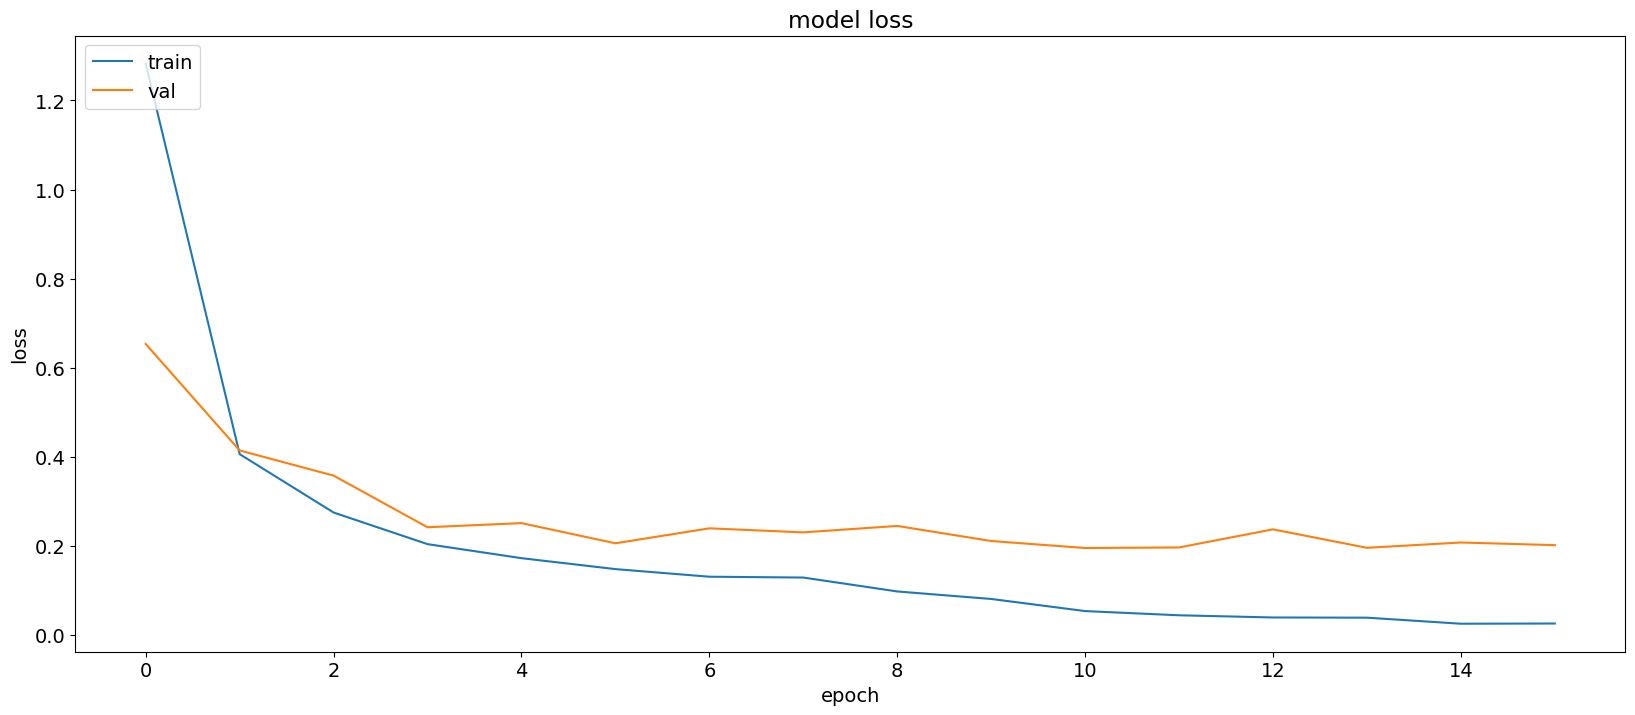

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_inceptionv2.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

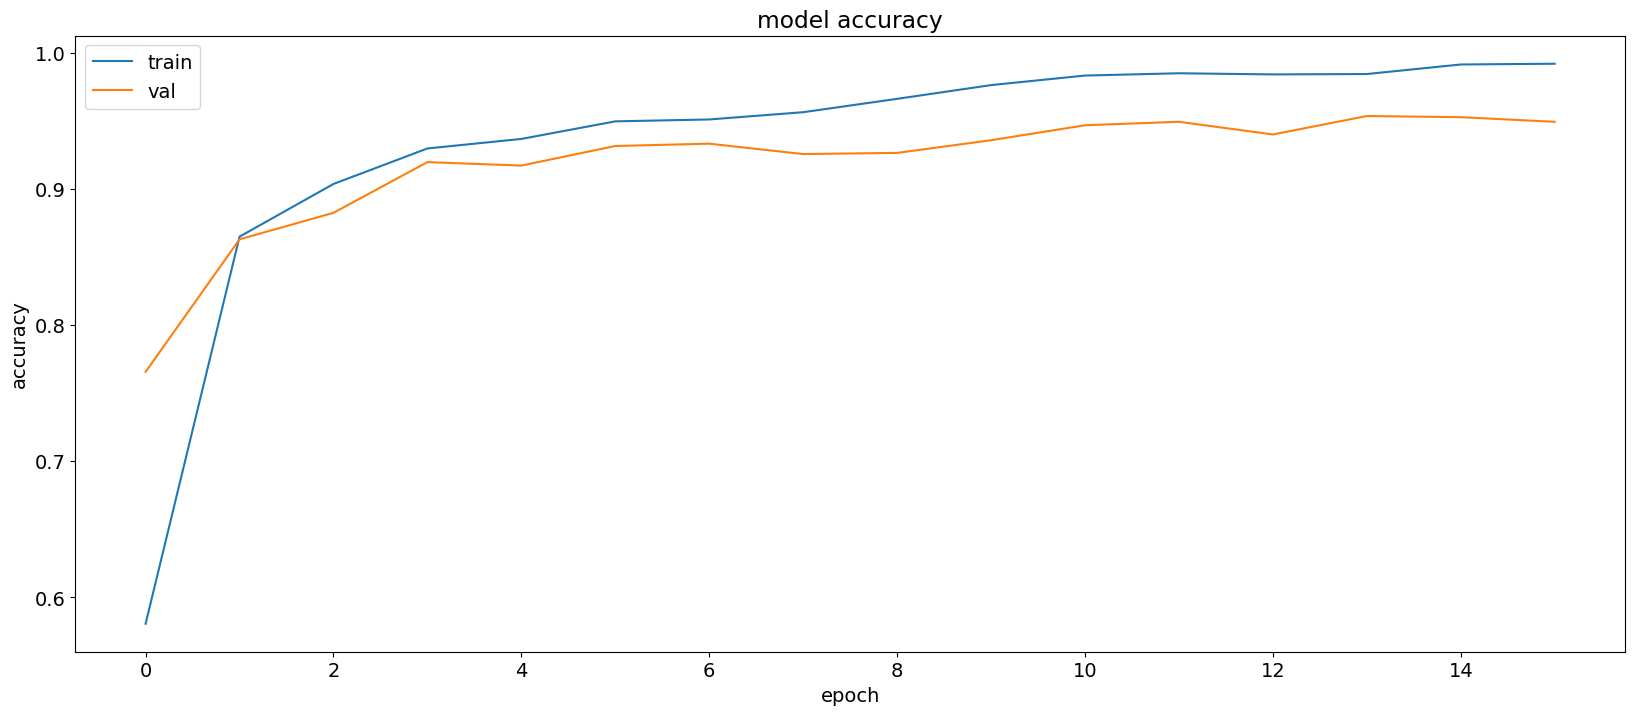

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

37/37 [==============================] - 33s 805ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.62      0.60      0.61        65
                 Charlock       0.99      1.00      0.99        97
                 Cleavers       0.99      0.96      0.97        71
         Common Chickweed       0.97      0.99      0.98       152
             Common wheat       0.98      0.93      0.95        55
                  Fat Hen       0.96      0.99      0.97       118
         Loose Silky-bent       0.82      0.86      0.84       163
                    Maize       1.00      0.96      0.98        55
        Scentless Mayweed       0.96      0.97      0.97       129
          Shepherds Purse       0.98      0.91      0.95        57
Small-flowered Cranesbill       1.00      0.98      0.99       124
               Sugar beet       0.98      0.97      0.97        96

                 accuracy                           0.94      1182
                macro avg       0.94      0.93      0.93    

Confusion Matrix:
[[ 39   0   0   0   1   0  25   0   0   0   0   0]
 [  0  97   0   0   0   0   0   0   0   0   0   0]
 [  0   0  68   1   0   1   0   0   1   0   0   0]
 [  0   0   0 151   0   0   1   0   0   0   0   0]
 [  0   0   1   0  51   1   1   0   0   0   0   1]
 [  0   0   0   1   0 117   0   0   0   0   0   0]
 [ 23   0   0   0   0   0 140   0   0   0   0   0]
 [  1   0   0   0   0   0   0  53   1   0   0   0]
 [  0   0   0   1   0   0   2   0 125   1   0   0]
 [  0   0   0   1   0   0   0   0   3  52   0   1]
 [  0   1   0   0   0   1   0   0   0   0 122   0]
 [  0   0   0   0   0   2   1   0   0   0   0  93]]


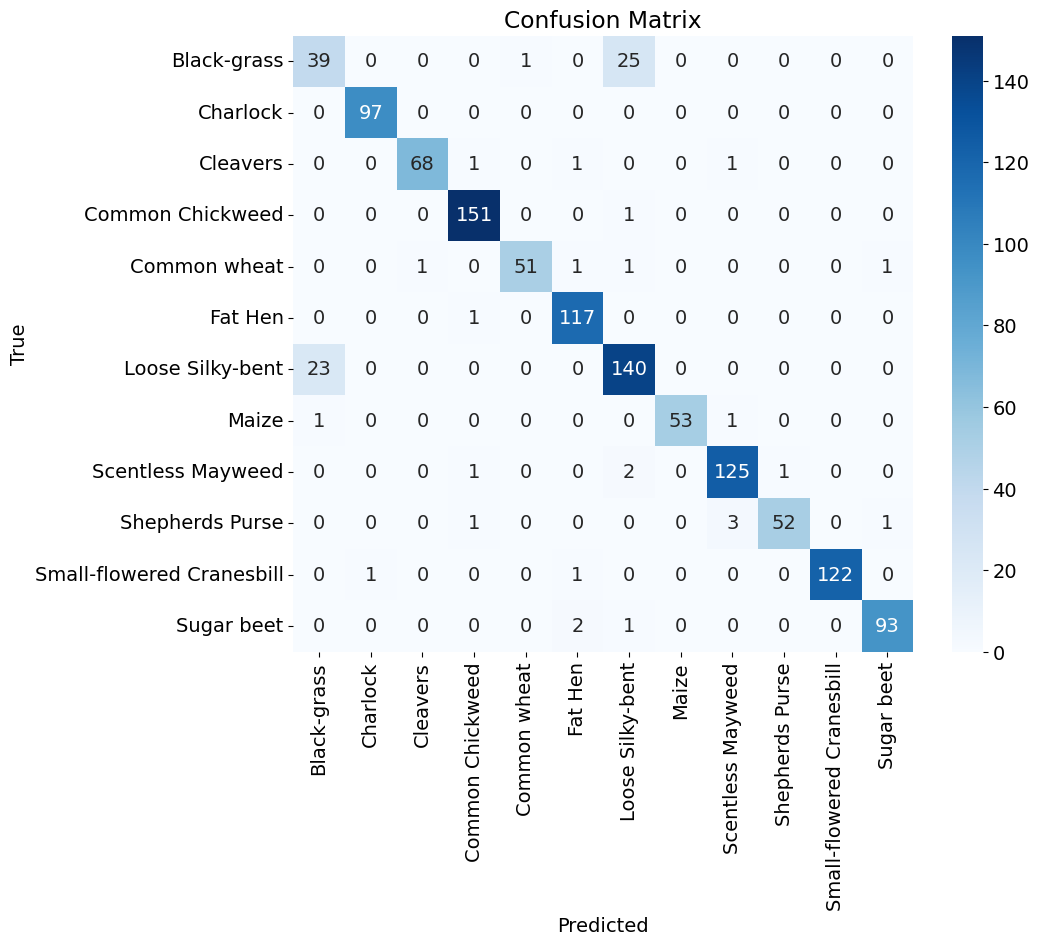

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model weights to a file
model.save_weights('model_weights_1.h5')